## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as Fn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset

from torch.optim import Adam

In [2]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
4


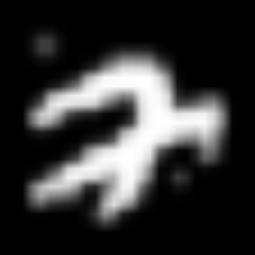

In [3]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[9]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [4]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.1 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 69793
Test subset size: 11632


In [5]:
class MyMNISTClassifier(nn.Module):
  def __init__(self, input_size):
    super(MyMNISTClassifier, self).__init__()


    self.linear1 = nn.Linear(input_size, 512)

    self.linear2 = nn.Linear(512, 128)

    self.linear3 = nn.Linear(128, 64)

    self.linear4 = nn.Linear(64, 62)

  def forward(self, x):


    x = torch.relu(self.linear1(x))

    x = torch.relu(self.linear2(x))

    x = torch.relu(self.linear3(x))

    x = self.linear4(x)
    return x

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 28 * 28
model = MyMNISTClassifier(input_size).to(device)

num_epochs = 10
lr = 1e-3

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

model.to(device)

print(f'Using device {device}')



Using device cuda


In [7]:
device

'cuda'

In [8]:

%%time
for epoch_no in range(num_epochs):

  model.train()
  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.view(-1, 28 * 28)


    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)


    batch_y_probs = model(batch_X)

    loss = criterion(batch_y_probs, batch_y)


    optimizer.zero_grad()

    loss.backward()


    optimizer.step()

    epoch_weighted_loss += len(batch_y) * loss.item()

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  train_losses.append(epoch_loss)




  model.eval()
  correctly_labelled = 0

  with torch.no_grad():
    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

        val_batch_X = val_batch_X.view(-1, 28 * 28)

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)


        val_batch_y_probs = model(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)

        val_epoch_weighted_loss += len(val_batch_y) * loss.item()


        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')


Epoch: 0, train_loss=1.1111647860858658, val_loss=0.7270540406484224. labelled 8887/11632 correctly (76.40130674002751% accuracy)
Epoch: 1, train_loss=0.6583090948556027, val_loss=0.6231390620278197. labelled 9266/11632 correctly (79.6595598349381% accuracy)
Epoch: 2, train_loss=0.5655935713355037, val_loss=0.5770684483536664. labelled 9376/11632 correctly (80.60522696011004% accuracy)
Epoch: 3, train_loss=0.5049323217415139, val_loss=0.548854470416965. labelled 9427/11632 correctly (81.04367262723521% accuracy)
Epoch: 4, train_loss=0.46649064698920006, val_loss=0.567774521845407. labelled 9429/11632 correctly (81.06086657496562% accuracy)
Epoch: 5, train_loss=0.4343920178671809, val_loss=0.5557058035835439. labelled 9503/11632 correctly (81.69704264099038% accuracy)
Epoch: 6, train_loss=0.40543132678461913, val_loss=0.5699791689358519. labelled 9513/11632 correctly (81.78301237964236% accuracy)
Epoch: 7, train_loss=0.3873691899691838, val_loss=0.5780543386526252. labelled 9482/11632 c

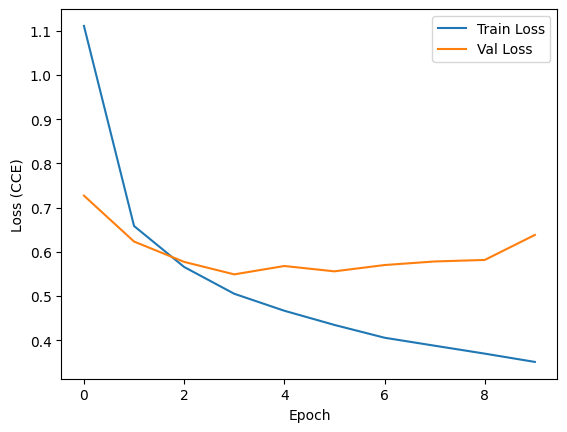

In [9]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

In [10]:
print(val_batch_X.shape, val_batch_y.shape)
print(val_batch_y_probs.shape)
print(val_batch_y_pred.shape)

print("\n\nTo verify softmax converts inputs into probabilities (sum of which is 1), let's sum those probabilities and see if we get 1's: \n")
print(f'{val_batch_y_probs.sum(1)=}')

print(f'\n{val_batch_y_probs.sum(1).shape=}')

print('\n\nLets see argmax in action')
print("Here's one of the input to argmax\n")
test_idx = 15
print(val_batch_y_probs[test_idx].cpu())
print("\n\nHere's its output")
print(val_batch_y_pred[test_idx].cpu())

torch.Size([16, 784]) torch.Size([16])
torch.Size([16, 62])
torch.Size([16])


To verify softmax converts inputs into probabilities (sum of which is 1), let's sum those probabilities and see if we get 1's: 

val_batch_y_probs.sum(1)=tensor([-1244.1613,  -721.4523,  -623.9423,  -809.6530, -1282.4954, -1333.9177,
         -969.4766,  -966.1157, -1280.1436,  -620.2872,  -707.8445,  -923.9098,
        -1153.6071, -1020.6995,  -549.3809,  -838.0607], device='cuda:0')

val_batch_y_probs.sum(1).shape=torch.Size([16])


Lets see argmax in action
Here's one of the input to argmax

tensor([-15.6423,  -5.3824, -18.3752, -13.8754,  11.7836,  -6.2653, -17.1229,
         -5.5922, -15.5847,  -0.5559, -16.8852, -23.7048, -19.0651, -30.9800,
        -25.1324,  -5.2185, -12.4570, -11.2674, -12.6434, -12.7844, -15.4039,
        -27.0816,  -9.9043, -12.9723, -19.8620, -15.4124, -21.2054, -26.1201,
        -16.7464,  -5.3653,  -6.0592,  -7.7447, -16.3107, -19.8542,   4.9514,
        -37.3935,  -7.2698, -21